# LoFi: Low-rank (extended) Kalman filter

In [1]:
import einops
import jax
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes_mini import callbacks
from sklearn.datasets import make_moons

In [2]:
from rebayes_mini.methods import low_rank_filter as lofi

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Moons' dataset

In [4]:
n_samples = 500
n_test = 300
data = make_moons(n_samples=(n_samples + n_test), random_state=3141, noise=0.15)
X, y = jax.tree_map(jnp.array, data)
X_test, y_test = X[-n_test:], y[-n_test:]
X, y = X[:-n_test], y[:-n_test]

key = jax.random.PRNGKey(314)

In [5]:
%%time
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x



model = MLP()
agent = lofi.BernoulliFilter(
    model.apply,
    dynamics_covariance=1e-7,
    rank=100
)

params = model.init(key, X)
bel_init = agent.init_bel(params, cov=1e-3)
bel, bel_hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)
bel = jax.block_until_ready(bel)

yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X)).ravel() > 0.5
(yhat == y).mean()

CPU times: user 14 s, sys: 898 ms, total: 14.9 s
Wall time: 7.41 s


Array(0.864, dtype=float32)

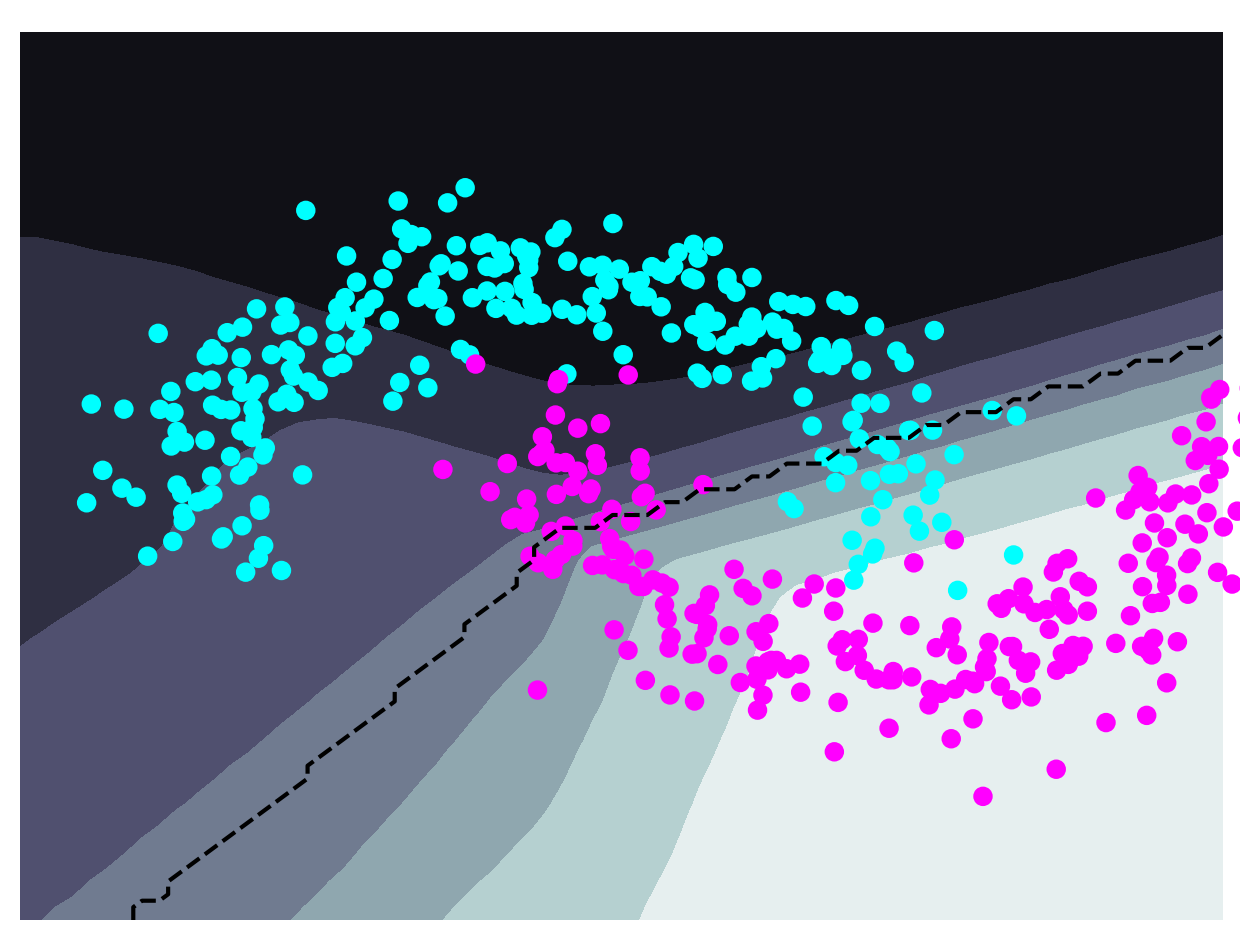

In [6]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Fashion MNIST